In [35]:
import re
import os
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
import seaborn as sns
import numpy as np
from IPython.display import HTML

In the first pass, we do a rough tokenization of the authentication log. We don't actually know how many different 'auth_source' types to expect, so we need to do some analysis to understand this better.

# Read the logs and do first coarse parsing

In [2]:
auth_parse = '^([A-Z][a-z]{2} [0-9\ ]\d \d{2}:\d{2}:\d{2}) ([a-z0-9A-Z][a-zA-Z0-9-]{0,62}) ([^:]+): (.*)$'
auth = []
with open("./all_auth_logs.txt") as f:
  lines = f.readlines()
  for line in lines:
    m = re.findall(auth_parse, line)
    auth_d = {
      'timestamp': dt.datetime.strptime(m[0][0], '%b %d %H:%M:%S').replace(year=2020),
      'hostname': m[0][1],
      'auth_source': m[0][2],
      'message': m[0][3]
    }
    auth.append(auth_d)

In [3]:
df = pd.DataFrame(auth)
df['auth_type'] = ''
df['auth_pid'] = -1

# Parse out the different auth sources

In [4]:
ssh_idx = df['auth_source'].str.startswith('sshd')
df.loc[ssh_idx, 'auth_type'] = 'ssh'
df.loc[ssh_idx, 'auth_pid'] = df.loc[ssh_idx, 'auth_source'].apply(lambda x: re.findall('sshd\[(\d+)\]',x)[0])

cron_idx = df['auth_source'].str.startswith('CRON')
df.loc[cron_idx, 'auth_type'] = 'cron'
df.loc[cron_idx, 'auth_pid'] = df.loc[cron_idx, 'auth_source'].apply(lambda x: re.findall('CRON\[\d+\]', x)[0])

login_idx = df['auth_source'].str.startswith('systemd-logind')
df.loc[login_idx, 'auth_type'] = 'physical_login'
df.loc[login_idx, 'auth_pid'] = df.loc[login_idx, 'auth_source'].apply(lambda x: re.findall('systemd-logind\[(\d+)\]', x)[0])

gnome_keyring = df['auth_source'].str.startswith('gnome-keyring-daemon')
df.loc[gnome_keyring, 'auth_type'] = 'gnome_keyring'
df.loc[gnome_keyring, 'auth_pid'] = df.loc[gnome_keyring, 'auth_source'].apply(lambda x: re.findall('gnome-keyring-daemon\[(\d+)\]', x)[0])

pkexec = df['auth_source'].str.startswith('pkexec')
df.loc[pkexec, 'auth_type'] = 'pkexec'

systemd = df['auth_source'].str.startswith('systemd')
df.loc[systemd, 'auth_type'] = 'physical_login'

polkitid = df['auth_source'].str.startswith('polk')
df.loc[polkitid, 'auth_type'] = 'polk'

gdm_password = df['auth_source'].str.startswith('gdm-password')
df.loc[gdm_password, 'auth_type'] = 'gdm_pass'

sudo = df['auth_source'].str.startswith('sudo')
df.loc[sudo, 'auth_type'] = 'sudo'

sudo = df['auth_source'].str.startswith('dbus')
df.loc[sudo, 'auth_type'] = 'dbus'

gdm = df['auth_source'].str.startswith('gdm-launch-env')
df.loc[gdm, 'auth_type'] = 'gdm-launch'

su = df['auth_source'].str.startswith('su[')
df.loc[su, 'auth_type'] = 'switch_user'

df.loc[df['auth_type'] == '', 'auth_type'] = 'other'

In [5]:
df

,timestamp,hostname,auth_source,message,auth_type,auth_pid
0,2020-11-01 00:17:01,computer,CRON[15214],pam_unix(cron:session): session opened for use...,cron,CRON[15214]
1,2020-11-01 00:17:01,computer,CRON[15214],pam_unix(cron:session): session closed for use...,cron,CRON[15214]
2,2020-11-01 01:17:01,computer,CRON[15270],pam_unix(cron:session): session opened for use...,cron,CRON[15270]
3,2020-11-01 01:17:01,computer,CRON[15270],pam_unix(cron:session): session closed for use...,cron,CRON[15270]
4,2020-11-01 01:22:27,computer,sshd[15276],Did not receive identification string from 162...,ssh,15276
...,...,...,...,...,...,...
88586,2020-10-16 15:58:43,computer,dbus-daemon[816],[system] Failed to activate service 'org.bluez...,dbus,-1
88587,2020-10-16 15:58:52,computer,sshd[3156],Accepted publickey for bdogg from 192.168.86.1...,ssh,3156
88588,2020-10-16 15:58:52,computer,sshd[3156],pam_unix(sshd:session): session opened for use...,ssh,3156
88589,2020-10-16 15:58:52,computer,systemd-logind[852],New session 3 of user bdogg.,physical_login,852


# Parse the interesting stuff - ssh

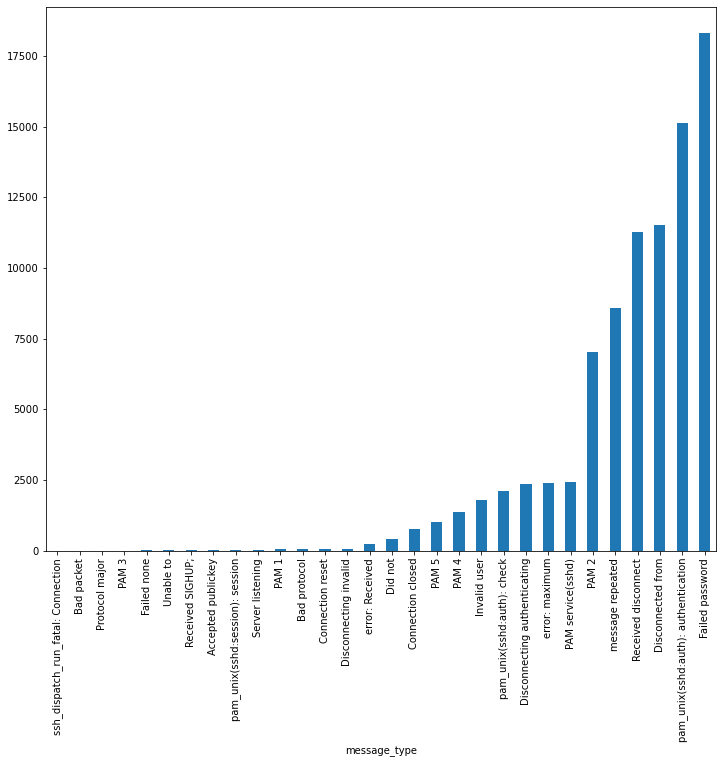

In [6]:
# Get a sense for the message types:
ssh_df = df[df['auth_type'] == 'ssh'].copy(deep=True)
ssh_df['message_type'] = ssh_df['message'].apply(lambda x: ' '.join(x.split(' ')[0:2]))
fig, ax = plt.subplots(figsize=(12, 10))
ssh_df.groupby('message_type').count()['hostname'].sort_values().plot.bar(ax=ax)

In [7]:
ssh_df['message_type'].value_counts() / ssh_df['message_type'].value_counts().sum()

Failed password                        0.210116
pam_unix(sshd:auth): authentication    0.173616
Disconnected from                      0.132309
Received disconnect                    0.129567
message repeated                       0.098426
PAM 2                                  0.080537
PAM service(sshd)                      0.027710
error: maximum                         0.027664
Disconnecting authenticating           0.026930
pam_unix(sshd:auth): check             0.024337
Invalid user                           0.020677
PAM 4                                  0.015834
PAM 5                                  0.011830
Connection closed                      0.008652
Did not                                0.004659
error: Received                        0.002742
Disconnecting invalid                  0.000746
Connection reset                       0.000711
Bad protocol                           0.000631
PAM 1                                  0.000597
Server listening                       0

In [8]:
for message in ssh_df[ssh_df['message'].str.startswith('pam_unix(sshd:auth)')]['message'][0:20]:
  print(message)

pam_unix(sshd:auth): check pass; user unknown
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=45.145.185.25
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=45.145.185.25  user=root
pam_unix(sshd:auth): check pass; user unknown
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=45.145.185.25
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=45.145.185.25  user=root
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=45.145.185.25  user=root
pam_unix(sshd:auth): check pass; user unknown
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=45.145.185.25
pam_unix(sshd:auth): check pass; user unknown
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=45.145.185.25
pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tt

It seems like the vast majority of the logs we're getting from auth is coming from failed SSH attempts. Lets look at some of them.

In [9]:
for message in ssh_df[ssh_df['message'].str.startswith('Failed')]['message'][0:20]:
  print(message)

Failed password for invalid user deploy from 45.145.185.25 port 54506 ssh2
Failed password for root from 45.145.185.25 port 59902 ssh2
Failed password for invalid user ansible from 45.145.185.25 port 49138 ssh2
Failed password for root from 45.145.185.25 port 37086 ssh2
Failed password for root from 45.145.185.25 port 42460 ssh2
Failed password for invalid user hadoop from 45.145.185.25 port 47844 ssh2
Failed password for invalid user ubnt from 45.145.185.25 port 53230 ssh2
Failed password for root from 45.145.185.25 port 58652 ssh2
Failed password for invalid user postgres from 45.145.185.25 port 35804 ssh2
Failed password for invalid user ubuntu from 45.145.185.25 port 41164 ssh2
Failed password for root from 45.145.185.25 port 46534 ssh2
Failed password for invalid user test from 45.145.185.25 port 51966 ssh2
Failed password for invalid user admin from 45.145.185.25 port 57320 ssh2
Failed password for root from 45.145.185.25 port 34476 ssh2
Failed password for invalid user oracle fr

In [10]:
parse_invalid = r'^Failed password for invalid user (\S+) from (\S+) port (\S+) ssh2$'
parse_valid   = r'^Failed password for (\S+) from (\S+) port (\S+) ssh2$'

In [11]:
for message in ssh_df[ssh_df['message'].str.startswith('Failed')]['message'][0:20]:
  print(re.findall(parse_invalid, message))

[('deploy', '45.145.185.25', '54506')]
[]
[('ansible', '45.145.185.25', '49138')]
[]
[]
[('hadoop', '45.145.185.25', '47844')]
[('ubnt', '45.145.185.25', '53230')]
[]
[('postgres', '45.145.185.25', '35804')]
[('ubuntu', '45.145.185.25', '41164')]
[]
[('test', '45.145.185.25', '51966')]
[('admin', '45.145.185.25', '57320')]
[]
[('oracle', '45.145.185.25', '39848')]
[]
[('user', '45.145.185.25', '50628')]
[('oracle', '45.145.185.25', '55998')]
[('test', '45.145.185.25', '33158')]
[('gituser', '45.145.185.25', '38542')]


In [12]:
for message in ssh_df[ssh_df['message'].str.startswith('Failed')]['message'][0:20]:
  print(re.findall(parse_valid, message))

[]
[('root', '45.145.185.25', '59902')]
[]
[('root', '45.145.185.25', '37086')]
[('root', '45.145.185.25', '42460')]
[]
[]
[('root', '45.145.185.25', '58652')]
[]
[]
[('root', '45.145.185.25', '46534')]
[]
[]
[('root', '45.145.185.25', '34476')]
[]
[('root', '45.145.185.25', '45444')]
[]
[]
[]
[]


Looks like its working - lets pull out all failed login attempts and understand what's going on here.

In [13]:
fail_df = ssh_df[ssh_df['message'].str.startswith('Failed')].copy(deep=True)

In [14]:
def parse_message(message):
  message = message['message']
  
  parse_invalid = r'^Failed password for invalid user (\S+) from (\S+) port (\S+) ssh2$'
  parse_valid   = r'^Failed password for (\S+) from (\S+) port (\S+) ssh2$'
  parse_none    = r'^Failed none for invalid user (\S+) from (\S+) port (\S+) ssh2$'
  parse_blank_1 = r'^Failed none for invalid user  from (\S+) port (\S+) ssh2$'
  parse_blank_2 = r'^Failed password for invalid user  from (\S+) port (\S+) ssh2$'
  
  m1 = re.findall(parse_invalid, message)
  m2 = re.findall(parse_valid, message)
  m3 = re.findall(parse_none, message)
  m4 = re.findall(parse_blank_1, message)
  m5 = re.findall(parse_blank_2, message)
  
  user = ''
  source_ip = ''
  port = ''
  
  try:
    user = m1[0][0]
    source_ip = m1[0][1]
    port = m1[0][2]
  except IndexError:
    try:
      user = m2[0][0]
      source_ip = m2[0][1]
      port = m2[0][2]
    except IndexError:
      try:
        user = m3[0][0]
        source_ip = m3[0][1]
        port = m3[0][2]
      except:
        try:
          user = 'none'
          source_ip = m4[0][0]
          port = m4[0][1]
        except:
          try:
            user = 'none'
            source_ip = m5[0][0]
            port = m5[0][1]
          except:
            pass
  
  return user, source_ip, port

message = fail_df.apply(func=parse_message, axis=1, result_type='expand').rename(columns={0:'user', 1:'source_ip', 2:'port'})

In [15]:
df = pd.concat([fail_df, message], axis=1) 

In [16]:
df['unixtime'] = df['timestamp'].apply(lambda x: time.mktime(x.timetuple()))

In [17]:
df['user'].value_counts()[df['user'].value_counts() > 6]

root             16163
admin              222
pi                 119
test               112
oracle             103
user               103
ftpuser             91
test1               77
usuario             59
test2               58
ubuntu              40
postgres            38
git                 35
jenkins             34
guest               30
ftpadmin            27
debian              27
ansible             27
hadoop              26
webadmin            26
user1               26
svn                 25
student             25
mysql               23
jira                22
ftptest             20
www                 20
support             19
dev                 19
user01              19
db                  18
server              18
ubnt                16
weblogic            15
tomcat              15
spark               14
vps                 14
demo                13
gituser             13
odoo                13
none                11
testuser            11
deploy              10
admnin     

In [18]:
# Pagate and view
rollover = 100

logins = df['user'].value_counts()\
  .sort_index()\
  .reset_index()\
  .rename(columns={'index':'login', 'user':'number'})

start_idx = 0
end_idx = rollover

pagated = []

while start_idx < len(logins):
  pagated.append(logins[start_idx:end_idx].reset_index().loc[:,['login', 'number']])
  start_idx += rollover
  end_idx += rollover
  
HTML(pd.concat(pagated, axis=1).to_html())

,login,number,login,number,login,number,login,number
0,!,1,dircreate,2,mother,1,user2,1.0
1,*****,1,docker,3,music,1,user8,1.0
2,0,1,drojas,1,myscada,1,username,2.0
3,1111,1,dubbo,1,mysql,23,usuario,59.0
4,11111,1,duni,4,nagesh,2,uucp,4.0
5,123,1,ec2-user,8,nagios,6,vnc,3.0
6,1234,3,ecs-user,1,ncuser,1,vps,14.0
7,12345,1,ecs-user1,1,newadmin,1,vyatta,1.0
8,18d062,1,edi,1,news,1,webadmin,26.0
9,22,1,edwin,1,newuser,2,weblogic,15.0


In [19]:
df_summary = pd.concat(
  [
    df[['source_ip', 'port']].groupby('source_ip').agg(lambda x: len(set(x))).rename(columns={'port':'num_ports_scanned'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').max().rename(columns={'timestamp':'max_timestamp'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').min().rename(columns={'timestamp':'min_timestamp'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').count().rename(columns={'timestamp':'number_of_attempts'}),
    df[['source_ip', 'user']].groupby('source_ip').agg(lambda x: len(set(x))).rename(columns={'user':'uname_count'}),
    df[['source_ip', 'timestamp']].groupby('source_ip').agg(lambda x: list(x)).rename(columns={'timestamp':'timeseries'}),
    df[['source_ip', 'unixtime']].groupby('source_ip').min().rename(columns={'unixtime':'min_unixtime'}),
    df[['source_ip', 'unixtime']].groupby('source_ip').max().rename(columns={'unixtime':'max_unixtime'}),
    df[['source_ip', 'unixtime']].groupby('source_ip').agg(lambda x: list(x)).rename(columns={'unixtime':'unixtime_timeseries'})
  ],
  axis=1
)
df_summary['ats'] = df_summary['number_of_attempts'] / (df_summary['max_unixtime'] - df_summary['min_unixtime'])
df_summary.sort_values(by='number_of_attempts', ascending=False).head(10)

,num_ports_scanned,max_timestamp,min_timestamp,number_of_attempts,uname_count,timeseries,min_unixtime,max_unixtime,unixtime_timeseries,ats
source_ip,,,,,,,,,,
218.92.0.205,2682,2020-10-23 16:25:12,2020-10-19 08:23:24,3422,1,"[2020-10-19 08:23:24, 2020-10-19 08:28:02, 202...",1.603096e+09,1.603470e+09,"[1603095804.0, 1603096082.0, 1603096154.0, 160...",0.009137
122.194.229.3,2710,2020-10-10 19:22:22,2020-10-08 23:49:49,3137,1,"[2020-10-08 23:49:49, 2020-10-08 23:50:48, 202...",1.602201e+09,1.602358e+09,"[1602200989.0, 1602201048.0, 1602201103.0, 160...",0.020012
218.92.0.204,1232,2020-10-27 09:14:39,2020-10-18 09:03:44,1556,1,"[2020-10-27 09:13:43, 2020-10-27 09:14:39, 202...",1.603012e+09,1.603790e+09,"[1603790023.0, 1603790079.0, 1603011824.0, 160...",0.001999
218.92.0.192,395,2020-10-08 23:13:54,2020-10-07 20:54:22,404,1,"[2020-10-07 20:54:22, 2020-10-07 20:58:54, 202...",1.602104e+09,1.602199e+09,"[1602104062.0, 1602104334.0, 1602104590.0, 160...",0.004263
213.108.218.84,64,2020-10-18 22:10:58,2020-10-18 00:43:55,246,14,"[2020-10-18 00:43:55, 2020-10-18 00:44:09, 202...",1.602982e+09,1.603059e+09,"[1602981835.0, 1602981849.0, 1602981862.0, 160...",0.003186
101.81.136.34,64,2020-10-21 12:13:27,2020-10-17 13:01:49,244,14,"[2020-10-21 12:08:13, 2020-10-21 12:08:28, 202...",1.602940e+09,1.603282e+09,"[1603282093.0, 1603282108.0, 1603282123.0, 160...",0.000712
118.71.135.111,236,2020-10-06 08:56:15,2020-10-06 08:13:45,237,143,"[2020-10-06 08:13:45, 2020-10-06 08:13:59, 202...",1.601972e+09,1.601975e+09,"[1601972025.0, 1601972039.0, 1601972042.0, 160...",0.092941
167.99.135.171,212,2020-10-21 16:10:01,2020-10-21 15:47:58,216,61,"[2020-10-21 15:47:58, 2020-10-21 15:48:05, 202...",1.603295e+09,1.603297e+09,"[1603295278.0, 1603295285.0, 1603295292.0, 160...",0.163265
45.148.10.15,154,2020-10-19 14:28:26,2020-10-19 12:43:11,154,81,"[2020-10-19 12:43:11, 2020-10-19 12:43:54, 202...",1.603111e+09,1.603118e+09,"[1603111391.0, 1603111434.0, 1603111476.0, 160...",0.024386


In [20]:
!pip install ipwhois

In [21]:
from ipwhois import IPWhois
import os
import sys
import numpy as np
import time
import json

ip_country = {}

for ip in df_summary.index.unique():
  try:
    with open("ip_to_country_mapping.json", "r") as f:
      ip_country = json.load(f)
  except:
    pass
  if ip not in ip_country:
    print("processing", ip, "            ", end='\r')
    resp = IPWhois(ip)
    country = resp.lookup_whois()['asn_country_code']
    ip_country[ip] = country
    with open("ip_to_country_mapping.json", "w") as f:
      json.dump(ip_country, f)
    
print("Done")


Doneessing 77.170.237.231              


In [22]:
df_summary['country'] = pd.Series(ip_country)

Text(0.5, 1.0, 'Attacks by Country')

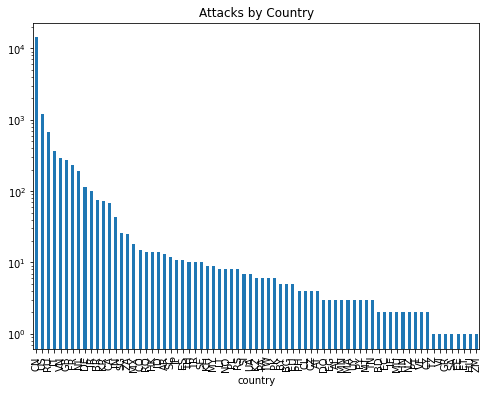

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
df_summary.groupby('country').sum()['number_of_attempts'].sort_values(ascending=False).plot.bar(ax=ax, logy=True)
ax.set_title("Attacks by Country")

In [53]:
top_over_100 = df_summary.groupby('country').sum()['number_of_attempts'].sort_values(ascending=False)
top_over_100 = top_over_100[top_over_100 > 100]

country
CN    14273
US     1190
RU      669
IT      364
VN      287
GB      274
FR      230
NL      190
DE      114
Name: number_of_attempts, dtype: int64

In [59]:
# plt_df = df_summary.loc[df_summary.index == '218.92.0.205']
countries = list(top_over_100.index)

In [62]:
print(countries, len(countries))


['CN', 'US', 'RU', 'IT', 'VN', 'GB', 'FR', 'NL', 'DE'] 9


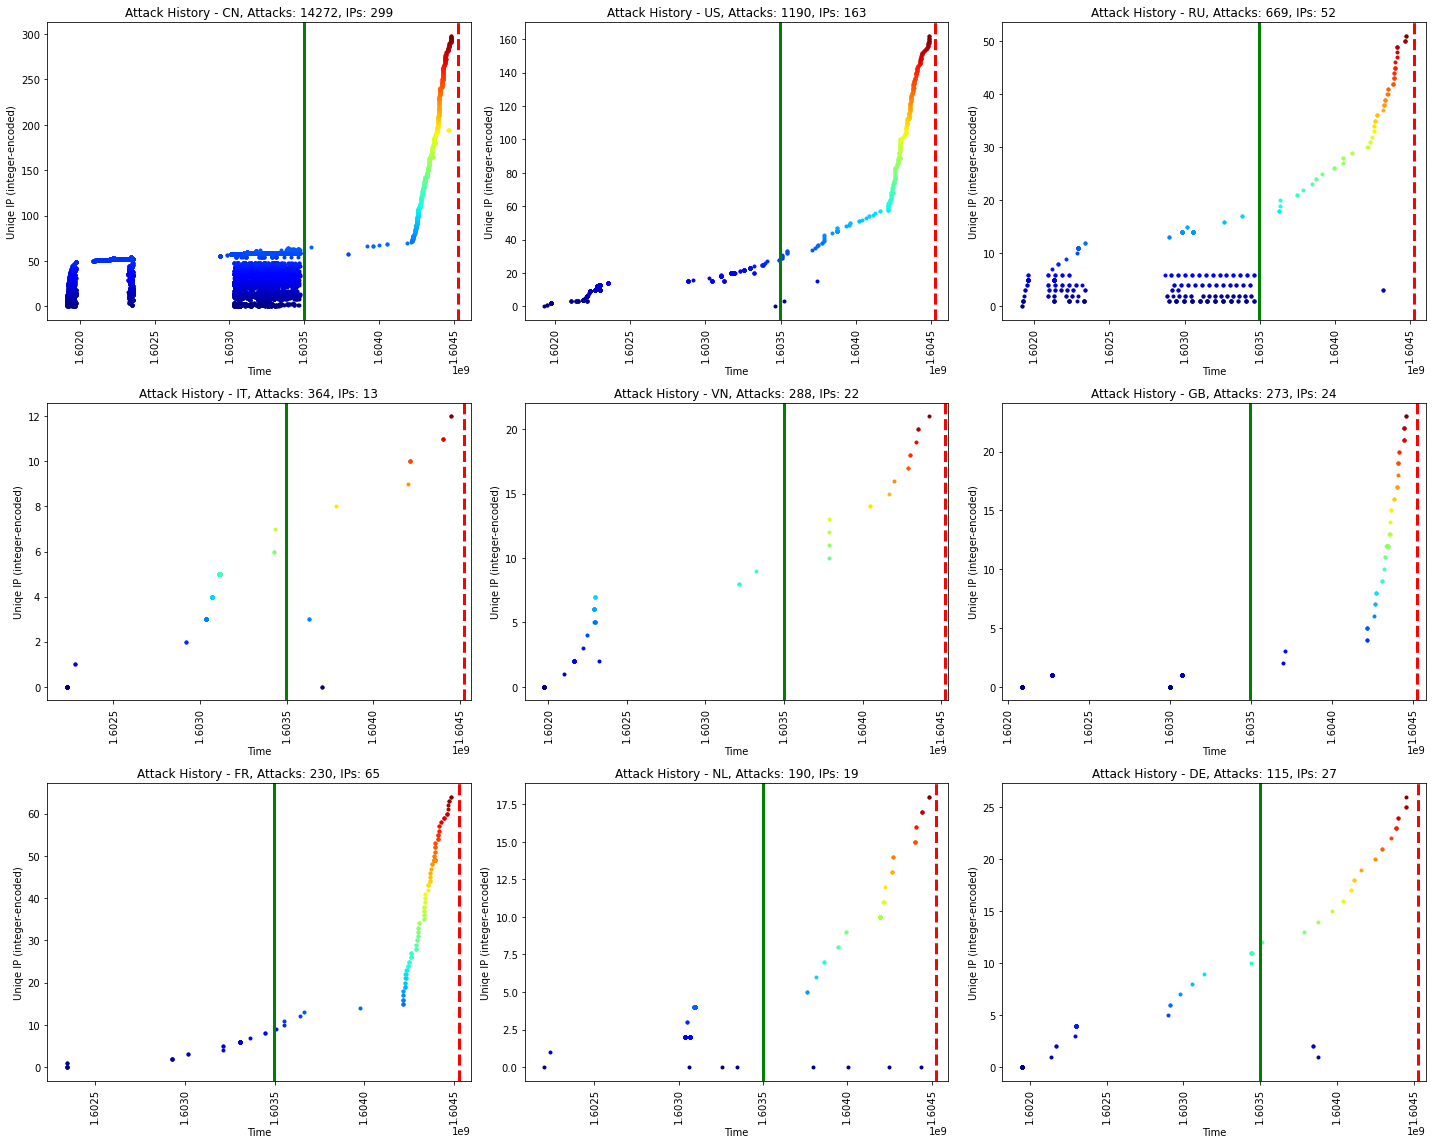

In [69]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,16))

for c_i, ax in enumerate(axes.reshape(-1)):
  plt.sca(ax)
  plt_df = df_summary.loc[df_summary['country'] == countries[c_i]]
  color = mpl.cm.jet(np.linspace(0, 1, len(plt_df)))
  attacks = 0
  for i, row in enumerate(plt_df.sort_values(by='min_unixtime').iterrows()):
    attacks += len(data['unixtime_timeseries'])
    ip_address = row[0]
    data = row[1]
    timeseries = data['unixtime_timeseries']

    plt.scatter(
      timeseries,
      np.full(shape=(len(timeseries),), fill_value=i),
      label=ip_address,
      marker='.',
      color=color[i],
    )
    plt.xticks(rotation='90')
  num_ips = len(plt_df.index)
  ax.axvline(x=time.mktime(dt.datetime.now().timetuple()), ymin=0, ymax=i, color='r', linestyle='--', linewidth=3)
  ax.axvline(x=time.mktime(dt.datetime(2020,10,24).timetuple()), ymin=0, ymax=i, color='g', linestyle='-', linewidth=3)
  ax.set_ylabel("Uniqe IP (integer-encoded)")
  ax.set_xlabel("Time")
  plt.title("Attack History - {}, Attacks: {}, IPs: {}".format(countries[c_i], attacks, num_ips))
plt.tight_layout()

The hard stop near October 25 was when fail2ban was installed on the server, with permanent bans implemented after three failed logins. Note that we saw one attack near the 29th where many new IP addresses started incoming. 

Large gaps in traffic correspond to the computer just being off.

In [42]:
new_labs = []
for tick in ax.get_xticklabels():
  type(tick)
  break